In [ ]:
!pip install pandas
!pip install scipy
!pip install torch

In [58]:
import os
from os.path import dirname, join as pjoin
import scipy.io as sio
import pandas as pd
import numpy as np

In [46]:
#Get raw and filtered data for S002

data_dir = pjoin(os.getcwd(),'..', 'dataset_phase1_ntx23')
S002_raw_mat_fname = pjoin(data_dir, 'train_S002_night1_hackathon_raw.mat')
S002_filt_mat_fname = pjoin(data_dir, 'train_S002_night1_hackathon_filt.mat')

S002_raw_mat_contents = sio.loadmat(S002_raw_mat_fname)
S002_filt_mat_contents = sio.loadmat(S002_filt_mat_fname)


S002_raw_EEG = S002_raw_mat_contents['EEG']
S002_filt_EEG = S002_filt_mat_contents['EEG']

fs = S002_raw_EEG['srate'].item()[0].item()

raw_data = S002_raw_EEG['data'].item()[0]
filt_data_1_to_35Hz = S002_filt_EEG['data'].item()[0]
filt_data_4_to_18Hz = S002_filt_EEG['data'].item()[1]

time = S002_raw_EEG['times'].item()[0]

In [28]:
#Load marker data for S002 into dataframe
marker_fname = pjoin(os.getcwd(),"..","dataset_phase1_ntx23","train_S002_labeled.csv")
markers_df = pd.read_csv(marker_fname)
markers_df.head()

,Timestamp,Epochs,SS1,SS0,K1,K0,REM1,REM0,Son1,Son0,Soff1,Soff0,A1,A0,MS1,MS0
0,8644,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,9770,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2,11064,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,12266,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,13515,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [76]:
import scipy
from scipy.fftpack import fft,fftshift
from matplotlib.pyplot import plot as plt

In [194]:
def getFFT(signal, timestamp:int,window_length:int=7500, timestamp_wind_loc:int=None, ret_abs:bool=False):
    """
    Get fast fourier transform of window_length sized sample of a signal
    Input Parameters:
    signal - full EEG signal
    timestamp - timestamp of event
    window_length - length of signal to perform fft on
    timestamp_win_loc - integer raning from 0 to length(window) - 1 indicating
    where to place window w.r.t to timestamp (e.g. event could be at the beginning of window "0")
    """
    if timestamp_wind_loc is None:
        timestamp_wind_loc = int(window_length/2) #center event if no index specified
    

    window_start_ind = timestamp - timestamp_wind_loc
    window_end_ind = window_start_ind + window_length - 1
    #print(timestamp)
    #print(window_start_ind,window_end_ind)
    signal_samp = signal[window_start_ind:window_end_ind]


    if ret_abs:
        return abs(fft(signal_samp))
    
    return fft(signal_samp)


def getSigFreqBands(freq_signal, fs:int=250, num_bands:int = 50)->list:
    """
    Get the most significant frequency bands present in the provided frequency signal

    Input Parameters:
    freq_signal - magnitude of a frequency domain signal (magnitude of fft return)
    fs - sampling rate of signal (in Hz)
    num_bands - number of largest frequencies to return

    Output Parameters:
    significant_bands
    magnitudes
    """
    L = len(freq_signal)
    assert num_bands < L

    frequencies = (fs/L)*np.array(range(0,int(np.ceil(L/2))))
    freq_signal = freq_signal[0:int(np.ceil(L/2))]
    #order frequency bands based on magnitude of signal
    ordered_bands = sorted(list(zip(freq_signal,frequencies)),reverse=True)
    
    #return num_bands largest frequencies
    list(zip(*ordered_bands[0:num_bands-1]))
    magnitudes,significant_bands = list(zip(*ordered_bands[0:num_bands-1]))
    return significant_bands, magnitudes

(4022.849, 3684.7913, 3512.8088, 3366.525, 3048.6167, 3023.283, 2931.94, 2822.6506, 2752.5188, 2715.116)


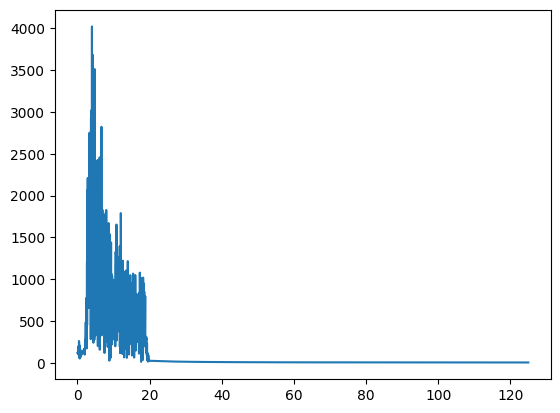

In [196]:
REM_detected = markers_df.loc[markers_df['REM1'] > 0, ['Timestamp']]
REM_detected.iloc[0]

window_length = 7500 #30 second window
ret_abs = False #get phase (not just magnitude)
timestamp_wind_loc = window_length/2 #center event



Y = abs(getFFT(signal=filt_data_4_to_18Hz, timestamp=REM_detected.iloc[5].item()))
frequencies,magnitudes = getSigFreqBands(Y,num_bands=50)

L = len(Y)
x_axis = (fs/L)*np.array(range(-int(np.ceil(L/2)),int(np.ceil(L/2-1))))
x_axis = (fs/L)*np.array(range(0,int(np.ceil(L/2))))
plt(x_axis, (Y[0:int(np.ceil(len(Y)/2))]))


In [198]:
import torch


[notice] A new release of pip available: 22.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
